### Analysis of Model Results

This notebook analyzes the output of the GMRF model, loading posterior samples to visualize probabilities and model parameters.



In [3]:
import os
import glob
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm
import functools
from dataloader import load_data
from knn_utils import load_condition_knn

# --- Global Context and Caching ---

@functools.lru_cache(maxsize=None)
def get_global_condition_info():
    """Loads the full list of conditions and their KNN graph."""
    print("Loading global condition info (condition list and KNN)...")
    _, _, full_condition_list = load_data()
    condition_knn = load_condition_knn()
    condition_to_idx = {name: i for i, name in enumerate(full_condition_list)}
    print("Global condition info loaded.")
    return full_condition_list, condition_knn['indices'], condition_to_idx

_reconstituted_draws_cache = {}

# --- Main Loading and Interpolation Logic ---

def load_beta_samples_from_combined(base_dir: str = 'Res/'):
    """Loads beta parameter samples from the latest combined results directory."""
    cache_key = 'beta_samples'
    if cache_key in _reconstituted_draws_cache:
        return _reconstituted_draws_cache[cache_key]

    combined_dirs = sorted(glob.glob(os.path.join(base_dir, 'sharded_hierarchical_gp_*')))
    if not combined_dirs:
        raise FileNotFoundError("No 'sharded_hierarchical_gp_*' directories found.")
    
    latest_dir = combined_dirs[-1]
    print(f"Loading beta parameters from: {latest_dir}")
    payload = np.load(os.path.join(latest_dir, 'combined_post_samples.npy'), allow_pickle=True).item()
    
    if 'beta_cond' in payload:
        betas = jnp.asarray(payload['beta_cond'])
    elif 'tau' in payload and 'lambdas' in payload:
        tau = jnp.asarray(payload['tau']).reshape(-1, 1)
        lambdas = jnp.asarray(payload['lambdas'])
        betas = tau * lambdas
    else:
        raise KeyError("'beta_cond' or ('tau'/'lambdas') not found in combined results.")
        
    _reconstituted_draws_cache[cache_key] = betas
    return betas

def _interpolate_missing_lambdas_weighted(lambda_draws, beta_cond_draws, knn_indices):
    """Fills NaN values in Lambda draws using beta-weighted nearest-neighbor interpolation."""
    print("Performing beta-weighted nearest-neighbor interpolation...")
    
    lambda_draws_np = np.asarray(lambda_draws)
    beta_cond_draws_np = np.asarray(beta_cond_draws)
    
    missing_indices = np.argwhere(np.isnan(lambda_draws_np[0, :, :]))

    for pat_idx, cond_idx in tqdm(missing_indices, desc="Interpolating"):
        neighbor_g_indices = knn_indices[cond_idx, 1:]  # Exclude self
        
        # For each draw, compute the weighted average
        for draw_idx in range(lambda_draws_np.shape[0]):
            valid_neighbors = []
            neighbor_lambdas = []
            
            for neighbor_idx in neighbor_g_indices:
                if not np.isnan(lambda_draws_np[draw_idx, pat_idx, neighbor_idx]):
                    valid_neighbors.append(neighbor_idx)
                    neighbor_lambdas.append(lambda_draws_np[draw_idx, pat_idx, neighbor_idx])
            
            if not valid_neighbors:
                continue

            # Get beta values for the valid neighbors for the current draw
            neighbor_betas = beta_cond_draws_np[draw_idx, valid_neighbors]
            
            # Weighted average
            weighted_avg = np.sum(neighbor_betas * np.array(neighbor_lambdas))
            lambda_draws_np[draw_idx, pat_idx, cond_idx] = weighted_avg
            
    print("Interpolation complete.")
    return jnp.asarray(lambda_draws_np)

def load_reconstituted_lambda_draws(base_dir: str = 'Res/'):
    """
    Loads, pads, and interpolates Lambda draws using beta-weighted NN.
    """
    cache_key = 'lambda_draws_interpolated_weighted'
    if cache_key in _reconstituted_draws_cache:
        print("Returning cached reconstituted Lambda draws.")
        return _reconstituted_draws_cache[cache_key]

    print("Loading, padding, and interpolating Lambda draws from shards...")
    full_condition_list, knn_indices, condition_to_idx = get_global_condition_info()
    beta_cond_draws = load_beta_samples_from_combined(base_dir)
    C_full = len(full_condition_list)
    
    shard_dirs = sorted(glob.glob(os.path.join(base_dir, 'gmrf_*_shard_*')))
    shard_samples_info = [np.load(os.path.join(d, 'mcmc_samples.npy'), allow_pickle=True).item() for d in shard_dirs]
    min_draws = min(s['Lambda'].shape[0] for s in shard_samples_info)
    
    padded_shards = []
    for shard_samples in shard_samples_info:
        lambda_shard = shard_samples['Lambda'][:min_draws, :, :]
        _, I_shard, C_shard = lambda_shard.shape
        padded_lambda = np.full((min_draws, I_shard, C_full), np.nan)
        
        # This part remains a simplification, assuming first C_shard conditions
        padded_lambda[:, :, :C_shard] = lambda_shard
        padded_shards.append(padded_lambda)

    reconstituted_padded = np.concatenate(padded_shards, axis=1)
    
    # Align beta draws with lambda draws
    beta_cond_aligned = beta_cond_draws[:min_draws, :C_full]
    
    reconstituted_final = _interpolate_missing_lambdas_weighted(reconstituted_padded, beta_cond_aligned, knn_indices)
    
    _reconstituted_draws_cache[cache_key] = reconstituted_final
    print("Reconstitution and interpolation complete.")
    return reconstituted_final




Loading, padding, and interpolating Lambda draws from shards...
Loading global condition info (condition list and KNN)...
Global condition info loaded.
Loading beta parameters from: Res/sharded_hierarchical_gp_20250903_144324
Performing beta-weighted nearest-neighbor interpolation...


Interpolating:   0%|          | 0/26439 [00:00<?, ?it/s]

Interpolation complete.
Reconstitution and interpolation complete.
Computed posterior mean probability matrix with shape: (6479, 43)


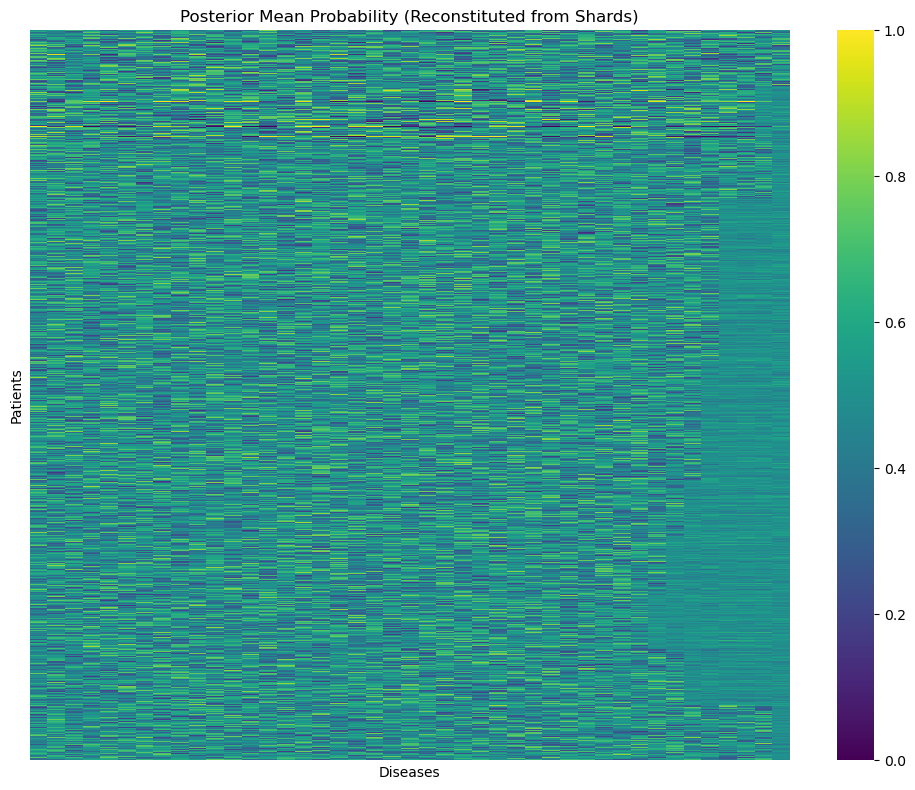

In [4]:
# Heatmap of posterior mean probabilities
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def _sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    return 1.0 / (1.0 + jnp.exp(-x))

# Load the reconstituted Lambda draws
# This function handles the logic of finding shards and concatenating Lambdas
lambda_draws = load_reconstituted_lambda_draws()

# Compute posterior mean probabilities
P_mean = _sigmoid(jnp.mean(lambda_draws, axis=0))
print(f"Computed posterior mean probability matrix with shape: {P_mean.shape}")

# Plot heatmap in original order
plt.figure(figsize=(10, 8))
sns.heatmap(np.asarray(P_mean), cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Mean Probability (Reconstituted from Shards)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()
plt.show()


Loaded probability draws: (4000, 6479, 43); std matrix shape: (6479, 43)


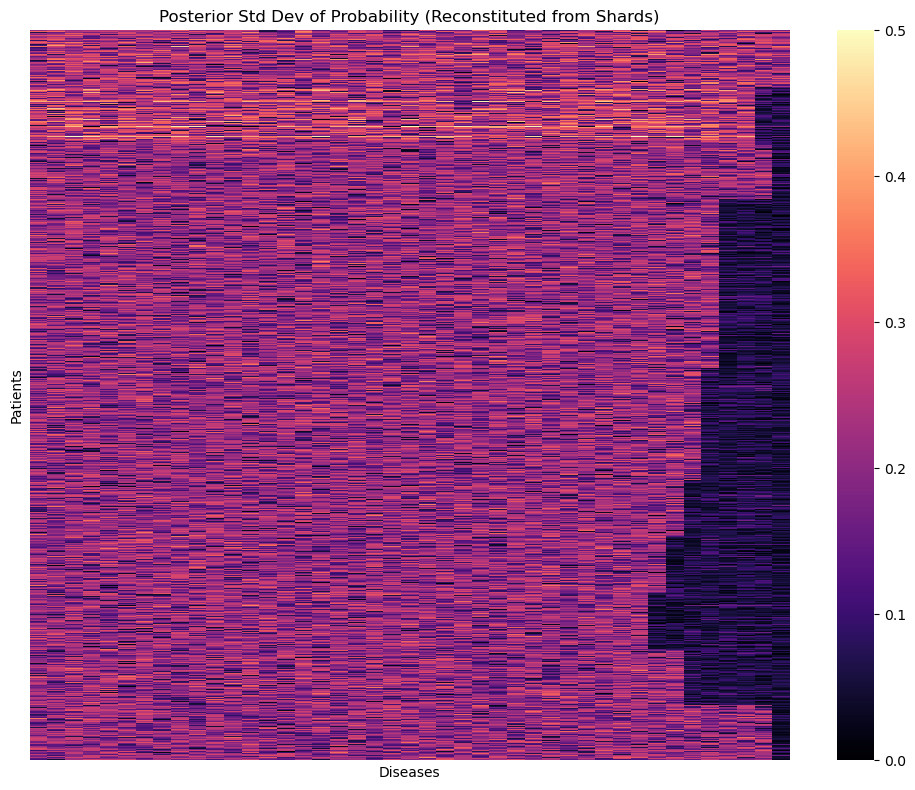

In [5]:
# Heatmap of posterior standard deviation of probabilities
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the reconstituted Lambda draws from the previous cell
# This avoids re-loading the data if the cache is populated
if 'lambda_draws' not in locals():
    lambda_draws = load_reconstituted_lambda_draws()

# Compute probabilities for each draw, then find the standard deviation
p_draws = _sigmoid(lambda_draws)
P_std = jnp.std(p_draws, axis=0)
print(f"Loaded probability draws: {p_draws.shape}; std matrix shape: {P_std.shape}")

# Plot heatmap of posterior std
plt.figure(figsize=(10, 8))
sns.heatmap(np.asarray(P_std), cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev of Probability (Reconstituted from Shards)')
plt.xlabel('Diseases')
plt.ylabel('Patients')
plt.tight_layout()
plt.show()


In [6]:
# Confusion Matrix and Classification Report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from dataloader import load_data

# Load ground truth from dataloader and align with predicted probabilities

def load_ground_truth_from_dataloader() -> np.ndarray:
    """
    Load A from dataloader, convert to 2D patient-by-condition binary matrix in {0,1}.
    """
    A, _, _ = load_data()
    A_2d = A[:, :, 0] if A.ndim == 3 else A
    if np.min(A_2d) < 0:
        A_2d = (A_2d + 1) / 2
    return A_2d.astype(np.int32)

# Use the P_mean computed in the previous cell
if 'P_mean' not in locals():
     raise NameError("'P_mean' not defined. Please run the cell that computes the posterior mean probability first.")

A_true_full = load_ground_truth_from_dataloader()
A_true = A_true_full[:P_mean.shape[0], :P_mean.shape[1]]

# Binarize predictions at 0.5 threshold
A_pred = (P_mean >= 0.5).astype(np.int32)

# Flatten for confusion matrix computation
y_true = A_true.flatten()
y_pred = np.asarray(A_pred).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, print classification report for more detail
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
[[131606 132602]
 [  7210   7179]]

Classification Report:
              precision    recall  f1-score   support

           0      0.948     0.498     0.653    264208
           1      0.051     0.499     0.093     14389

    accuracy                          0.498    278597
   macro avg      0.500     0.499     0.373    278597
weighted avg      0.902     0.498     0.624    278597



Loading beta parameters from: Res/sharded_hierarchical_gp_20250903_144324


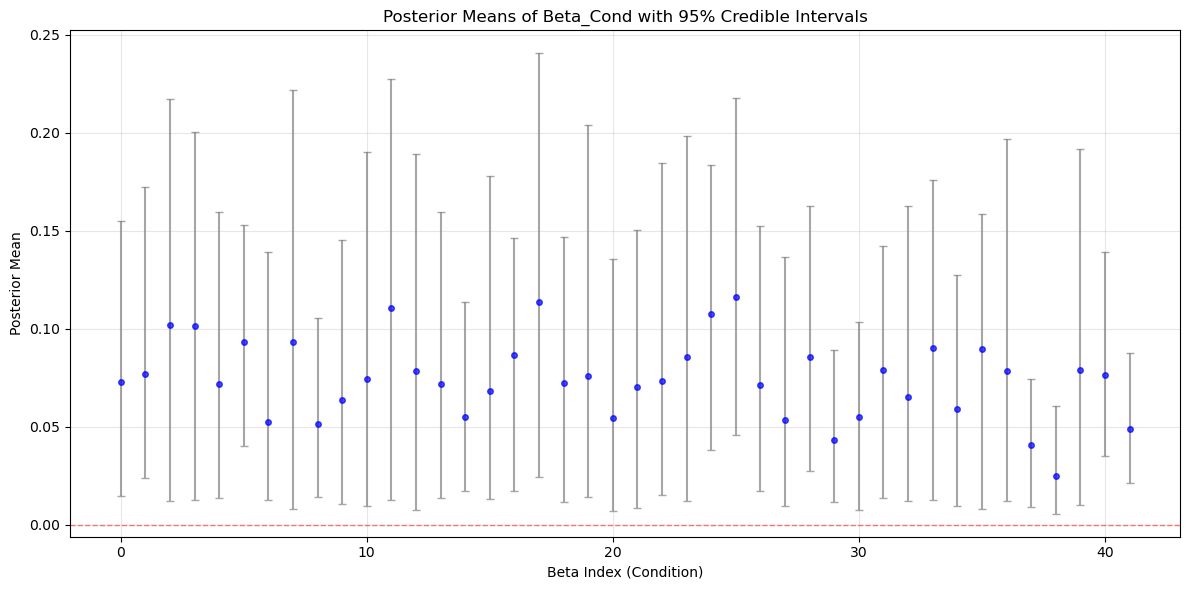


Summary of Beta_Cond Parameters:
Number of conditions: 42
Mean of all beta means: 0.0745
Number of betas with 95% CI excluding zero: 42


In [7]:
# Analysis of Beta Parameters from Combined Results
import os
import glob
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def load_beta_samples_from_combined(base_dir: str = 'Res/'):
    """
    Loads beta parameter samples from the latest combined results directory.
    It reconstructs 'beta_cond' if it is not directly available.
    """
    combined_dirs = sorted(glob.glob(os.path.join(base_dir, 'sharded_hierarchical_gp_*')))
    if not combined_dirs:
        raise FileNotFoundError(f"No 'sharded_hierarchical_gp_*' directories found in '{base_dir}'.")
    
    latest_combined_dir = combined_dirs[-1]
    print(f"Loading beta parameters from: {latest_combined_dir}")
    
    payload = np.load(os.path.join(latest_combined_dir, 'combined_post_samples.npy'), allow_pickle=True).item()
    
    if 'beta_cond' in payload:
        beta_samples = jnp.asarray(payload['beta_cond'])
    elif 'tau' in payload and 'lambdas' in payload:
        tau = jnp.asarray(payload['tau']).reshape(-1, 1)
        lambdas = jnp.asarray(payload['lambdas'])
        beta_samples = tau * lambdas
    else:
        raise KeyError("'beta_cond' or ('tau' and 'lambdas') not found in combined results.")
        
    return beta_samples

# Load the beta samples
try:
    beta_samples = load_beta_samples_from_combined()
    
    num_betas = beta_samples.shape[1]

    # Compute posterior mean and 95% credible interval
    beta_means = jnp.mean(beta_samples, axis=0)
    beta_lower, beta_upper = jnp.percentile(beta_samples, jnp.array([2.5, 97.5]), axis=0)

    # Compute error bars
    yerr = jnp.vstack([beta_means - beta_lower, beta_upper - beta_means])

    # Plot posterior means with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(np.arange(num_betas), np.asarray(beta_means), yerr=np.asarray(yerr), 
                 capsize=3, capthick=1, fmt='o', markersize=4, 
                 color='blue', ecolor='gray', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    plt.xlabel('Beta Index (Condition)')
    plt.ylabel('Posterior Mean')
    plt.title('Posterior Means of Beta_Cond with 95% Credible Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary of Beta_Cond Parameters:")
    print(f"Number of conditions: {num_betas}")
    print(f"Mean of all beta means: {jnp.mean(beta_means):.4f}")
    
    excludes_zero = jnp.sum((beta_lower > 0) | (beta_upper < 0))
    print(f"Number of betas with 95% CI excluding zero: {excludes_zero}")

except (FileNotFoundError, KeyError) as e:
    print(f"Skipping beta analysis: {e}")
